## Simple XGBoost tutorial


We will use the trivial **Iris Dataset** which you can get from directly from sklearn or from the UCI repository.

First of all, let's import what is needed:

In [1]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split

Load the Iris dataset and split in train and test following the thumb rule of 80/20:

In [2]:
iris = datasets.load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [3]:
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Use **DMatrix** as data structures for both train and test. 

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
You can construct DMatrix from numpy.arrays:

In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Set XGBoost parameters:

merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).

In [5]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

Create a model and fit it with params:

(We could have used also XGBClassifier, which is a scikit-learn compatible class. It is basically just a wrapper over the xgb.train function).

In [6]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train')])

[0]	train-merror:0.01667
[2]	train-merror:0.01667
[4]	train-merror:0.01667
[6]	train-merror:0.01667


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:08:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	train-merror:0.01667
[10]	train-merror:0.01667
[12]	train-merror:0.01667
[14]	train-merror:0.01667
[16]	train-merror:0.01667
[18]	train-merror:0.00833
[19]	train-merror:0.00833


In [7]:
from sklearn.metrics import precision_score

preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.92 %


It is possible to show with an histogram the importance of each feature:

In [8]:
%matplotlib inline
from xgboost import plot_importance

**Gain:** it implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

<Axes: title={'center': 'Gain'}, xlabel='F score', ylabel='Features'>

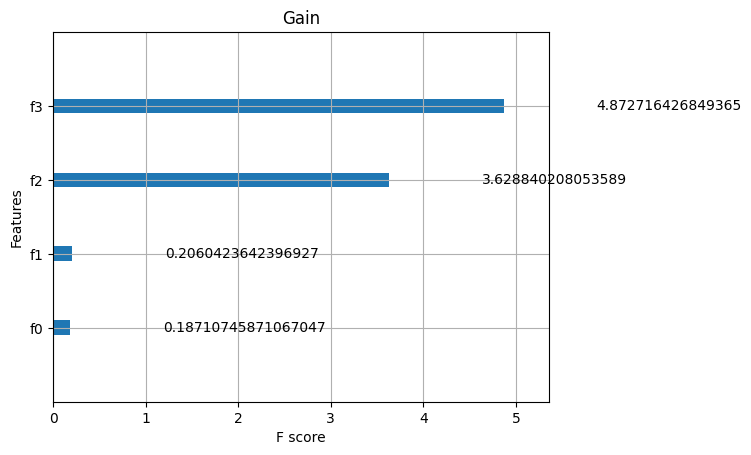

In [9]:
plot_importance(model, importance_type='gain', title='Gain')

**Cover:** The Cover metric means the relative number of observations related to this feature. Therefore is the number of observations for which the leaf node is determined by the feature. This number will be calculated for all the features in the dataset and the cover will be expressed as a percentage over all features' cover metrics.

<Axes: title={'center': 'Cover'}, xlabel='F score', ylabel='Features'>

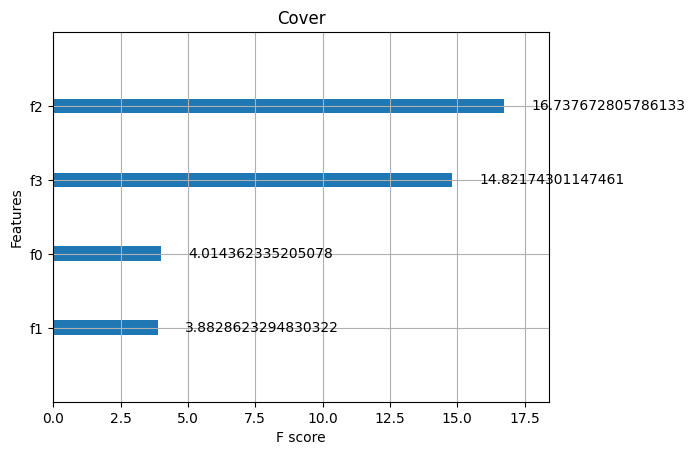

In [10]:
plot_importance(model, importance_type='cover', title='Cover')

**Weight (Frequence):** is the percentage representing the relative number of times a particular feature occurs in the trees of the model. Is the number of splits in which the particular feature occurred.

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

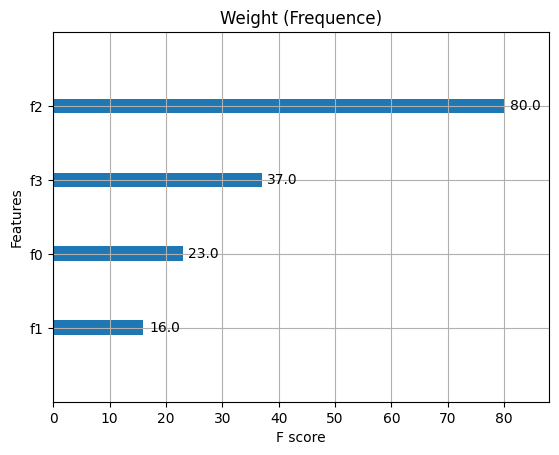

In [11]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

In order to avoid overfitting, we can use the early stopping technique looking at the error on our local validation set. Let's try it:

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [13]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train'), (dval, 'validation')],
                  early_stopping_rounds=20)

[0]	train-merror:0.02083	validation-merror:0.00000
[2]	train-merror:0.02083	validation-merror:0.00000
[4]	train-merror:0.02083	validation-merror:0.00000
[6]	train-merror:0.01042	validation-merror:0.04167
[8]	train-merror:0.01042	validation-merror:0.04167
[10]	train-merror:0.00000	validation-merror:0.08333
[12]	train-merror:0.00000	validation-merror:0.04167
[14]	train-merror:0.00000	validation-merror:0.08333
[16]	train-merror:0.00000	validation-merror:0.08333
[18]	train-merror:0.00000	validation-merror:0.08333
[19]	train-merror:0.00000	validation-merror:0.08333


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:10:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


### If we plot the precision and feature weight we may see changes in the values

In [15]:
X_train

array([[5. , 3.3, 1.4, 0.2],
       [4.8, 3.4, 1.9, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.7, 0.2],
       [6.9, 3.1, 5.4, 2.1],
       [7.7, 2.6, 6.9, 2.3],
       [5.5, 2.4, 3.8, 1.1],
       [6.7, 2.5, 5.8, 1.8],
       [4.9, 3. , 1.4, 0.2],
       [6.5, 3. , 5.2, 2. ],
       [5.8, 2.7, 3.9, 1.2],
       [7.2, 3.6, 6.1, 2.5],
       [5.7, 2.8, 4.5, 1.3],
       [4.3, 3. , 1.1, 0.1],
       [4.9, 2.4, 3.3, 1. ],
       [5.2, 3.5, 1.5, 0.2],
       [6.8, 2.8, 4.8, 1.4],
       [4.4, 2.9, 1.4, 0.2],
       [6.7, 3. , 5.2, 2.3],
       [4.8, 3.4, 1.6, 0.2],
       [6.2, 3.4, 5.4, 2.3],
       [6.3, 2.9, 5.6, 1.8],
       [5.7, 2.5, 5. , 2. ],
       [5.8, 2.7, 5.1, 1.9],
       [5.1, 3.5, 1.4, 0.3],
       [6.3, 2.8, 5.1, 1.5],
       [5.4, 3.7, 1.5, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [6.3, 2.7, 4.9, 1.8],
       [4.9, 3.1, 1.5, 0.1],
       [5.7, 3.8, 1.7, 0.3],
       [6. , 3.4, 4.5, 1.6],
       [6.5, 3. , 5.8, 2.2],
       [4.6, 3

In [16]:
preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.92 %


<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

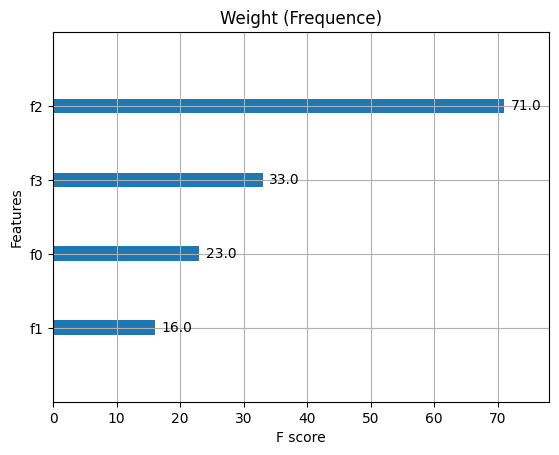

In [17]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

## How to use XGBoost in RecSys?

## Hint: reranking and hybridization

### Steps:
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

## Dummy example

In [19]:
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
import numpy as np
import scipy.sparse as sps
from challenge.utils.functions import read_data

cutoff_list = [10]
data_file_path = '../challenge/input_files/data_train.csv'
users_file_path = '../challenge/input_files/data_target_users_test.csv'
URM_all_dataframe, users_list = read_data(data_file_path, users_file_path)

URM_all = sps.coo_matrix(
    (URM_all_dataframe['Data'].values, (URM_all_dataframe['UserID'].values, URM_all_dataframe['ItemID'].values)))
URM_all = URM_all.tocsr()

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage=0.80)

evaluator = EvaluatorHoldout(URM_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 2541 (19.5%) Users that have less than 1 test interactions


### Let's select the recommendations to use to train XGBoost

Several options are possible:
- Take the best recommender and select, say, the top-100 recommended items
- Take multiple recommenders and use the union of their recommendations
- ...

In this example a single model will be used to select the candidate user-item interactions to use for XGBoost

In [20]:
from Recommenders.GraphBased import RP3betaRecommender, P3alphaRecommender

RP3_recommender = RP3betaRecommender.RP3betaRecommender(URM_train)
RP3_recommender.fit(topK=30, alpha=0.26362900188025656, beta=0.17133265585189086, min_rating=0.2588031389774553,
                    implicit=True, normalize_similarity=True)
RP3_Wsparse = RP3_recommender.W_sparse

RP3betaRecommender: URM Detected 878 ( 6.7%) users with no interactions.
RP3betaRecommender: URM Detected 466 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22348 (100.0%), 4473.26 column/sec. Elapsed time 5.00 sec


## Build the dataframe with the predictions

Creating dataframes can be quite computationally expensive. Never use "append" or iteratively concatenate new elements when you have to run a significant number of iterations, it will take forever. Initialize instead the dimension you want.

In [21]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [22]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
13020,NaN
13021,NaN
13022,NaN


In [23]:
cutoff = 20

for user_id in tqdm(range(n_users)):    
    recommendations = RP3_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|██████████| 13025/13025 [00:06<00:00, 2039.81it/s]


In [24]:
training_dataframe

,ItemID
UserID,
0,"[14897, 14894, 14892, 14908, 14889, 14888, 148..."
1,"[15, 36, 101, 506, 123, 1546, 3311, 429, 1057,..."
2,"[47, 11, 196, 50, 1522, 28, 949, 16, 1227, 109..."
3,"[4252, 857, 375, 970, 239, 511, 159, 750, 128,..."
4,"[2, 17, 11, 28, 119, 4, 42, 146, 50, 299, 249,..."
...,...
13020,"[6450, 6452, 6198, 5725, 6749, 105, 1422, 155,..."
13021,"[6429, 6451, 6179, 5915, 20505, 7027, 175, 133..."
13022,"[1411, 1668, 1446, 1767, 809, 1674, 1555, 4688..."


### Let's transform the dataframe so that we have one recommendation per row

In [25]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,14897
0,14894
0,14892
0,14908
0,14889
...,...
13024,15122
13024,554
13024,6215


### We should add the target column, which is the correct recommendation as contained in the validation data

In [26]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,1,15
1,1,354
2,1,429
3,1,1108
4,1,1217
...,...,...
76592,13024,7472
76593,13024,8431
76594,13024,13605
76595,13024,13823


In [27]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,14897,left_only
1,0,14894,left_only
2,0,14892,left_only
3,0,14908,left_only
4,0,14889,left_only
...,...,...,...
260495,13024,15122,both
260496,13024,554,both
260497,13024,6215,left_only
260498,13024,706,left_only


In [28]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,14897,False
1,0,14894,False
2,0,14892,False
3,0,14908,False
4,0,14889,False
...,...,...,...
260495,13024,15122,True
260496,13024,554,True
260497,13024,6215,False
260498,13024,706,False


## Now let's add some features. For example, the prediction of other algorithms

This may take some time so it is a good idea to save this data and load it instead of calculating the scores every time.

In [29]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.GraphBased import P3alphaRecommender
from Recommenders.SLIM import SLIMElasticNetRecommender

topPop = TopPop(URM_train)
topPop.fit()

p3alpha = P3alphaRecommender.P3alphaRecommender(URM_train)
p3alpha.fit(topK=64, alpha=0.35496275558011753, min_rating=0.1, implicit=True,
                       normalize_similarity=True)

slim = SLIMElasticNetRecommender.SLIMElasticNetRecommender(URM_train)
slim.fit(l1_ratio=0.005997129498003861, alpha=0.004503120402472539,
                         positive_only=True, topK=45)


other_algorithms = {
    "TopPop": topPop,
    "P3alpha": p3alpha,
    "SLIM": slim,
}


TopPopRecommender: URM Detected 878 ( 6.7%) users with no interactions.
TopPopRecommender: URM Detected 466 ( 2.1%) items with no interactions.
P3alphaRecommender: URM Detected 878 ( 6.7%) users with no interactions.
P3alphaRecommender: URM Detected 466 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 4476.40 column/sec. Elapsed time 4.99 sec
SLIMElasticNetRecommender: URM Detected 878 ( 6.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 466 ( 2.1%) items with no interactions.
SLIMElasticNetRecommender: Processed 13431 (60.1%) in 5.00 min. Items per second: 44.76
SLIMElasticNetRecommender: Processed 22348 (100.0%) in 8.98 min. Items per second: 41.46


In [30]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 13025/13025 [00:19<00:00, 655.39it/s]


,UserID,ItemID,Label,TopPop,P3alpha,SLIM
0,0,14897,False,3.0,0.000000,0.000000
1,0,14894,False,2.0,0.000000,0.000000
2,0,14892,False,6.0,0.000000,0.000000
3,0,14908,False,3.0,0.000000,0.000000
4,0,14889,False,5.0,0.000000,0.000000
...,...,...,...,...,...,...
260495,13024,15122,True,4.0,0.045660,0.068497
260496,13024,554,True,84.0,0.085318,0.106295
260497,13024,6215,False,13.0,0.120551,0.090609
260498,13024,706,False,70.0,0.084170,0.086307


## The popularity of the item, the user activity etc..

In [31]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM,item_popularity
0,0,14897,False,3.0,0.000000,0.000000,3
1,0,14894,False,2.0,0.000000,0.000000,2
2,0,14892,False,6.0,0.000000,0.000000,6
3,0,14908,False,3.0,0.000000,0.000000,3
4,0,14889,False,5.0,0.000000,0.000000,5
...,...,...,...,...,...,...,...
260495,13024,15122,True,4.0,0.045660,0.068497,4
260496,13024,554,True,84.0,0.085318,0.106295,84
260497,13024,6215,False,13.0,0.120551,0.090609,13
260498,13024,706,False,70.0,0.084170,0.086307,70


## Or the profile length

In [32]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM,item_popularity,user_profile_len
0,0,14897,False,3.0,0.000000,0.000000,3,0
1,0,14894,False,2.0,0.000000,0.000000,2,0
2,0,14892,False,6.0,0.000000,0.000000,6,0
3,0,14908,False,3.0,0.000000,0.000000,3,0
4,0,14889,False,5.0,0.000000,0.000000,5,0
...,...,...,...,...,...,...,...,...
260495,13024,15122,True,4.0,0.045660,0.068497,4,45
260496,13024,554,True,84.0,0.085318,0.106295,84,45
260497,13024,6215,False,13.0,0.120551,0.090609,13,45
260498,13024,706,False,70.0,0.084170,0.086307,70,45


## The same can be done with item features

It is better in this case to first create a sparse matrix replicating the rows needed and ten transform it into a sparse dataframe

**WARNING** dataframes are not sparse structures and this may cause the memory requirements to explode

features_df = pd.DataFrame.sparse.from_spmatrix(ICM_genres)
features_df

training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

## Then you can train XGBoost to rerank those prediction using as lable whether they should be recommended or not

In [33]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM,item_popularity,user_profile_len
0,0,14897,False,3.0,0.000000,0.000000,3,0
1,0,14905,False,4.0,0.000000,0.000000,4,0
2,0,14893,False,2.0,0.000000,0.000000,2,0
3,0,14895,False,3.0,0.000000,0.000000,3,0
4,0,14904,False,2.0,0.000000,0.000000,2,0
...,...,...,...,...,...,...,...,...
260495,13024,4076,False,20.0,0.214790,0.205201,20,45
260496,13024,733,False,74.0,0.292493,0.265903,74,45
260497,13024,706,False,70.0,0.084170,0.086307,70,45
260498,13024,350,False,135.0,0.147043,0.159330,135,45


### To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidates for each user (30) all groups have the same length.

In [34]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([20, 20, 20, ..., 20, 20, 20])

In [35]:
from xgboost import XGBRanker

In [36]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [39]:
training_dataframe.drop(columns=["Label"])

,UserID,ItemID,TopPop,P3alpha,SLIM,item_popularity,user_profile_len
0,0,14897,3.0,0.000000,0.000000,3,0
1,0,14905,4.0,0.000000,0.000000,4,0
2,0,14893,2.0,0.000000,0.000000,2,0
3,0,14895,3.0,0.000000,0.000000,3,0
4,0,14904,2.0,0.000000,0.000000,2,0
...,...,...,...,...,...,...,...
260495,13024,4076,20.0,0.214790,0.205201,20,45
260496,13024,733,74.0,0.292493,0.265903,74,45
260497,13024,706,70.0,0.084170,0.086307,70,45
260498,13024,350,135.0,0.147043,0.159330,135,45


In [41]:
training_dataframe["ItemID"] = training_dataframe["ItemID"].astype(int)

y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

### Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will ten need to rank as we do in any other recommender model.

### Important: In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

In [42]:
# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([ 0.06436722, -0.51014686, -0.20700783, -0.03745223, -0.09213661,
       -0.13595112,  0.15228388, -0.20736687,  0.08331767, -0.14498761,
       -0.04855457,  0.4348261 ,  0.19804247,  0.19804247,  0.19804247,
        0.3729646 ,  0.14209574,  0.18778299,  0.18854119,  0.1312511 ],
      dtype=float32)

### We can have a look to the feature importance to assess which are the most informative ones

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

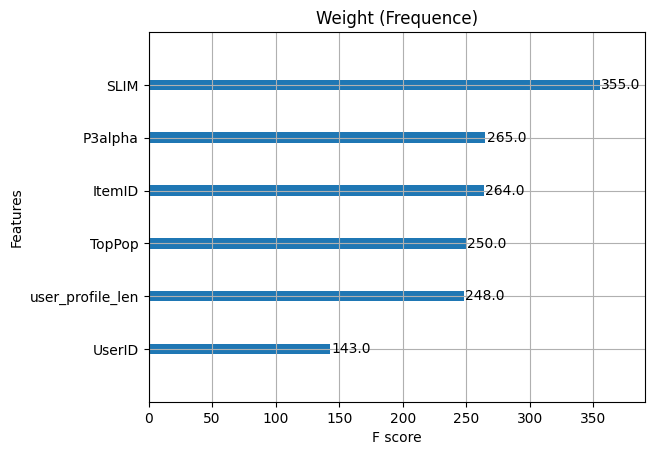

In [43]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

### Note, here ItemID and UserID are provided as integers, meaning that XGBoost will use them as any integer number and may split user groups according to whether their ID is < or > of a certain value. This makes no sense of course because the IDs are not ordinal, they are categorical and the specific numerical value of an IDs has no relation with the semantics of the problem. 

How to address this? 
- Use one-hot-encoded values -> drawback, the number of columns becomes very large
- Use the native "Categorical" data type -> drawback, it is still experimental and may not work very well
- Use another representation of the IDs, such as target encoding -> drawback, some further processing is needed and no teaching material is provided on this

In [44]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [45]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [46]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([ 0.11372588, -0.16833682, -0.19006275,  0.06004903, -0.02878875,
       -0.07479855,  0.10717294,  0.05478696,  0.06488095, -0.017274  ,
        0.05478696,  0.16163704,  0.12365691,  0.12365691,  0.12365691,
        0.12365691,  0.12365691,  0.12365691,  0.08391649,  0.12365691],
      dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

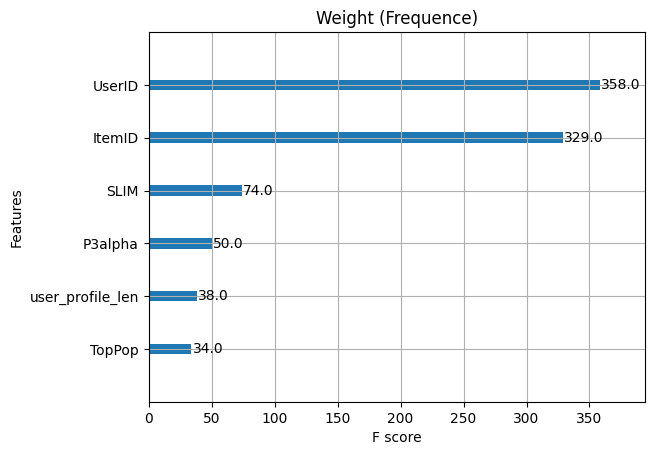

In [47]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

### How to perform hyperparameter tuning?
The issue with this method is that you need a label which should be an item the user has not interacted with but that is a correct recommendation. In practice the idea is:
- Split the data in the usual training-validation-test
- Split the training data in two: one part you use to train the recommenders and another you use as the hidden Label to train XGBoost
- Evaluate your predictions on the validation data as you did for any other recommender model. Use this to select the optimal hyperparameters.
- Given the selected hyperparameters, train the recommender models on all the available data and use all the available data to compute the features used by XGBoost.

Challenge: Since the label we use for training XGBoost is the split of a split, it may happen that the actual correct recommendations are very few. This will result in a problem that is very unbalanced towards zero and will make the training difficult and the evaluation noisy. To mitigate this you may use k-fold cross validation and define the valdation result of a certain hyperparameter configuration as the average obtained with k different training-label splits.